In [1]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import seaborn as sns
import imp
import matrixes
imp.reload(matrixes)
import random_initialization as rand_init
imp.reload(rand_init)

<module 'random_initialization' from 'C:\\Users\\ALemikhov\\Documents\\Slb research\\01_ResModel\\random_initialization.py'>

# Reservoir model

Задача - построить 2D модель резервуара. Для начала необходимо задать свойства полости, такие как $\phi,\ S_{water}, S_{oil} = 1 - S_{water}, c_r, c$. Также величины, фигурирующие в законе Дарси: $k, \mu, \rho$. Будем считать модель изотропной и варьировать лишь $S_{oil}$

# Построение формы резервуара
## Насыщение
Будем задавать значения каким -нибудь рандомным способом, но красивым. В `sklearn` есть множество методов создания выборок для классификации, мне понравился этот. Так мы и будем определять где вода, а где нефть.

In [2]:
ns = 50000
x_min, x_max = -1.3, 1.3
y_min, y_max = -1.3, 1.3

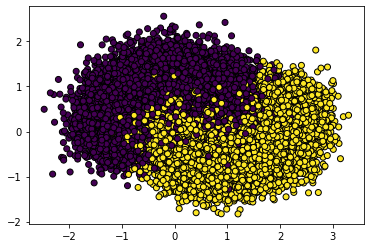

In [3]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()          

Перенесём всё это на меньший сетку фиксированного размера c фиксированным шагом по следующим правилам
<ol>
<li>Если в ячейке не оказывается ни одного элемента - значит это не пористая структура.

<li>Если оказывается несколько - берёс среднее арифметическое
</ol>

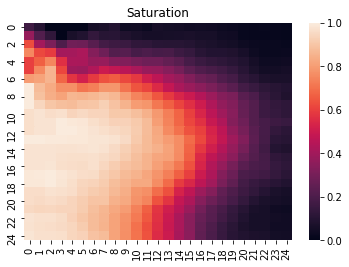

In [4]:
Satur_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=1, x_min=-1,
                                                 y_min=-1, y_max=1
                                                )
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

# Глубина
Покачто у нас резервуар 2D и вид сверху, нужно задать функцию глубины.

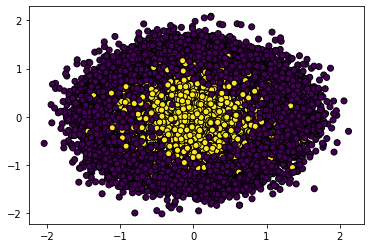

In [5]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()    

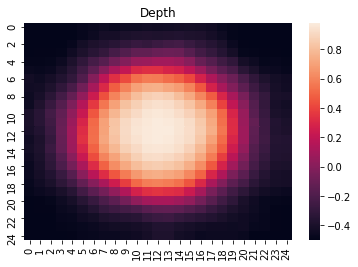

In [6]:
depth_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

# Пористость
Возьмём её пока такую же как матрицу проницаемости

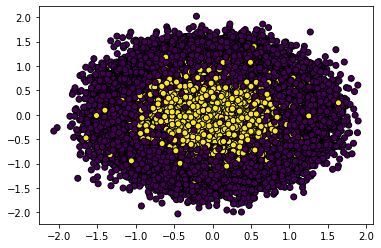

In [7]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

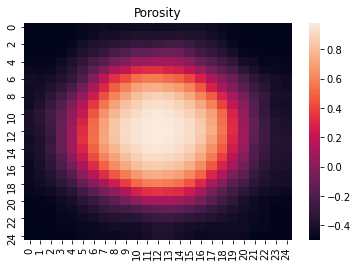

In [8]:
porosity_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("Porosity")
plt.show()

# Проницаемость k
Возьмём такую же как матрицу насыщений

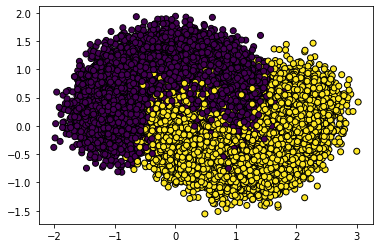

In [9]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()     

c:\users\alemikhov\appdata\local\programs\python\python38\lib\site-packages\scipy\ndimage\filters.py:1527: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,


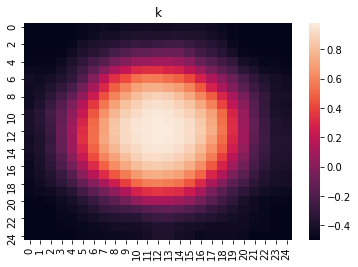

In [10]:
k_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max
                                                )
sns.heatmap(depth_matrix)
plt.title("k")
plt.show()

## Матрицы свойств собраны
Для построения модели эти матрицы нужно вытянуть в матрицы размера $n_x \cdot n_y$, сделать около диагональными и уметь обращаться к свойствам резервуара на границе ячеек для матриц $k$ и $depth$

Для $k$ в лекции вывели формулу, её реализаия представлена в классе `KMatrix`. 

$$k_{i+\frac{1}{2}, j} = \frac{\Delta x_{i, j} + \Delta y_{i+1, j}}{\frac{\Delta x_{i, j}}{k_{i, j}} + \frac{\Delta x_{i+1, j}}{k_{i+1, j}}}$$
\
\
$$k_{i, j+\frac{1}{2}} = \frac{\Delta y_{i, j} + \Delta y_{i, j+1}}{\frac{\Delta y_{i, j}}{k_{i, j}} + \frac{\Delta y_{i, j+1}}{k_{i, j+1}}}$$

### Глубина тоже важна на стыках
Аккуратненько реализуем 
$$d_{i,\ j+\frac{1}{2}} = \frac{d_{i, j} + d_{i, j+1}}{2}$$
\
\
$$d_{i+\frac{1}{2},\ j} = \frac{d_{i, j} + d_{i+1, j}}{2}$$

# Модель
$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = {\frac{\partial}{\partial x} \big(\frac{k k_{ro}}{\mu_o B_o}\frac{\partial \vec p}{\partial x}\big)} + \tilde
{q_o}$$
И точно такое же но для индекса не `o`, означающего `oil` а для `w`, `water`

Рассписав $\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o}$ по `chain rule`

$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = \frac{\phi}{B_o} \frac{\partial S_o}{\partial t} + \big( \frac{\phi S_o}{B_o} B_o \frac{\partial}{\partial p}\big[ \frac{1}{B_o} \big]  + \frac{\phi S_o}{B_o} \cdot \frac{1}{\phi} \frac{\partial \phi}{\partial p} \big) \frac{\partial p}{\partial t}$$ (1)

Введём константы сжимаемости

$$\frac{\partial}{\partial t} \frac{\phi S_{oil}}{B_o} = \frac{\phi}{B_o} \frac{\partial S_o}{\partial t} + \big( \frac{\phi S_o}{B_o} c_o  + \frac{\phi S_o}{B_o} c_r \big) \frac{\partial p}{\partial t}$$

Пока поставим себе цель обновлять давление в нашей 2D картинке. Нужно избавиться от насыщений. Домножим выражение 1 на $\frac{B_o}{B_w}$. Во многих местах окажется сумма насыщений.

$$\frac{\phi}{B_w} \frac{\partial}{\partial t} \big(S_w + S_o\big) + \frac{\phi}{B_w}\big[ S_{o}c_o + S_{w}c_w + c_{r} (S_o + S_w)\big] \frac{\partial p}{\partial t} = \big(\frac{B_o}{B_w} \frac{k k_{ro}}{\mu_o B_o} +  \frac{k k_{rw}}{\mu_w B_w}\big) \nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$

Учтём что $S_w + S_o = 1$. Это достигается постоянством давления на границе и потоком воды ($\tilde{q}$ нужно только на границе, в других местах 0).

Заменим $S_{o}c_o + S_{w}c_w + c_{r} (S_o + S_w) = c_t$ и получим:

$$\frac{\phi c_t}{B_w} \frac{\partial p}{\partial t} = \big(\frac{k k_{ro}}{\mu_o B_w} + \frac{k k_{ro}}{\mu_w B_w} \big) \nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$
\
$$\frac{\phi ct}{B_w} \frac{\partial p}{\partial t} = \tilde{k}\nabla J(p) + \frac{B_o}{B_w}\tilde{q_o} + \tilde{q_w}$$

Точно такое же уравнение было решено [Here](https://www.youtube.com/watch?v=2hxV5kJojRM&list=PLKNU3sBDzHbI4qD55I189y02asrHrgz6_&index=2). Перепишем ответ

$$\frac{\phi c_t}{B_w}\frac{p_{i, j}^{n+1} - p_{i,j}^{n}}{\Delta t} \Delta V_{i, j}=
\Big( \\
\tilde{k}_{i+\frac{1}{2}, j} d_{i+\frac{1}{2}, j} \Delta y_{j} \frac{p_{i+1, j} - p_{i, j}}{\Delta x_{i+\frac{1}{2}}} +\\
\tilde{k}_{i-\frac{1}{2}, j} d_{i-\frac{1}{2}, j} \Delta y_{j} \frac{p_{i-1, j} - p_{i, j}}{\Delta x_{i-\frac{1}{2}}} + \\
\tilde{k}_{i-\frac{1}{2}, j} d_{i, j+\frac{1}{2}} \Delta x_{i}  \frac{p_{i, j+1} - p_{i, j}}{\Delta y_{j+\frac{1}{2}}} + \\
\tilde{k}_{i-\frac{1}{2}, j} d_{i, j-\frac{1}{2}} \Delta x_{j}  \frac{p_{i, j-1} - p_{i, j}}{\Delta y_{j-\frac{1}{2}}}
\Big)\\
+ \frac{B_o}{B_w}\tilde{q_o} \Delta V_{i, j} + \tilde{q_w} \Delta V_{i, j}$$
\
$\Delta V_{i, j} = \Delta x_{i, j} \Delta y_{i, j} d_{i,j}$


### T Interblock matrix
Теперь можно для каждого стыка ячеек можно указать "проводимость"
$$T_{i+\frac{1}{2}, j} =\tilde{k}_{i+\frac{1}{2}, j} d_{i+\frac{1}{2}, j} \frac{ \Delta y_{j}}{\Delta x_{i+\frac{1}{2}}}$$
\
\
$$T_{i+\frac{1}{2}, j} =\tilde{k}_{i, j+\frac{1}{2}} d_{i, j+\frac{1}{2}} \frac{ \Delta x_{j}}{\Delta y_{i+\frac{1}{2}}}$$

Также обозначим $B^{w}_{i, j} = \frac{\phi_{i, j}c_t V_{i, j}}{B_{w}}$

## Матрица для обновлений

Для того чтобы обновлять значения в ячейках, используя матричные умножения, нужно превратить матрицу свойств в вектор(reshape(-1)). Матрица же для обновления будет очень хитрой.

## .reshape(-1)

In [31]:
x = np.array([[0, 1, 2],
              [3, 4, 5],
              [6, 7, 8]
             ])
x.reshape(-1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Матрица обновлений

$$B_{i, j}^{w}\frac{p_{i, j}^{n+1} - p_{i,j}^{n}}{\Delta t} +
T_{i+\frac{1}{2}, j} (p_{i, j} - p_{i+1, j}) +
T_{i+\frac{1}{2}, j} (p_{i, j} - p_{i-1, j}) + 
T_{i+\frac{1}{2}, j} (p_{i, j} - p_{i, j+1}) + 
T_{i+\frac{1}{2}, j} (p_{i, j} - p_{i, j-1}) + 
\frac{B_o}{B_w}\tilde{q_o} \Delta V_{i, j} + \tilde{q_w} \Delta V_{i, j} = 0$$

Перейдём от $p_{i, j}$ к $p_n$

$$p_{i, j} = p_{n_y \cdot i + j}$$

$$B_{n_y \cdot i + j}^{w}\frac{p_{n_y \cdot i + j}^{n+1} - p_{n_y \cdot i + j}^{n}}{\Delta t} +\\
T_{i+\frac{1}{2}, j} (p_{n_y \cdot i + j} - p_{n_y \cdot (i+1) + j}) +\\
T_{i-\frac{1}{2}, j} (p_{n_y \cdot i + j} - p_{n_y \cdot (i-1) + j}) + \\
T_{i, j+\frac{1}{2}} (p_{n_y \cdot i + j} - p_{n_y \cdot i + j+1}) + \\
T_{i, j-\frac{1}{2}} (p_{n_y \cdot i + j} - p_{n_y \cdot i + j-1}) + \\
\frac{B_o}{B_w}\tilde{q_o} \Delta V_{n_y \cdot i + j} + \tilde{q_w} \Delta V_{n_y \cdot i + j} = 0$$

Сделаем $B^w$ диагональную матрицу

$B^{w} \frac{\partial \vec{p}}{\partial t} + T_{matrix} \vec{p} + \frac{B_o}{B_w}\tilde{q_o} \Delta V_{n_y \cdot i + j} + \tilde{q_w} \Delta V_{n_y \cdot i + j}$

Но как же устроена $T_{matrix}$?

$$
\begin{pmatrix}
B^w_{0} & 0 &\dots \\
0 & B^w_{1} & \dots \\
\vdots &  \vdots & \ddots \\
\end{pmatrix}
\frac{\partial \vec{p}}{\partial t} + 
\begin{pmatrix}
0&0&0&\ddots&\ddots&\ddots&\dots& \\
-T_{i-\frac{1}{2}, j}&0&0&-T_{i, j-\frac{1}{2}}&
T_{i+\frac{1}{2},j}+T_{i-\frac{1}{2},j} + T_{i,j+\frac{1}{2}}+T_{i,j-\frac{1}{2}}
&-T_{i, j+\frac{1}{2}}&0&0& -T_{i+\frac{1}{2}, j}\\
0&\ddots&0&0&\ddots&\ddots&\ddots&0&0\\
\end{pmatrix}
\vec{p} +$$
\
\
\
\
$$\frac{B_o}{B_w}\tilde{q_o} \Delta V_{n_y \cdot i + j} + \tilde{q_w} \Delta V_{n_y \cdot i + j}
=0
$$

Матрица получается трёхдиагональная, но есть элементы с отрицательными индексами, которые должны поддерживать начальные условия